<a href="https://colab.research.google.com/github/ryanalumkal/DE1-SoC-Voice-Controlled-Rover/blob/main/ECE243_SpeechCommands_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Source: https://www.tensorflow.org/tutorials/audio/simple_audio

In [1]:
!pip install tensorflow

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
DATASET_PATH = '/content/data/mini_speech_commands_extracted/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data')

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store') & (commands != "no") & (commands != "yes")] #UPDATE LIST OF COMMANDS
print('Commands:', commands)

Commands: ['up' 'down' 'go' 'right' 'stop' 'left']


In [5]:
for root, dirs, files in os.walk(data_dir):
  print(dirs)

['no', 'up', 'yes', 'down', 'go', 'right', 'stop', 'left']
[]
[]
[]
[]
[]
[]
[]
[]


In [6]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    labels = "inferred",
    class_names = ['up', 'right', 'stop', 'left', 'go', 'down'],
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000, #2 seconds for DE1_SoC
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)
saved_labels = label_names

Found 6000 files belonging to 6 classes.
Using 4800 files for training.
Using 1200 files for validation.

label names: ['up' 'right' 'stop' 'left' 'go' 'down']


In [7]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [8]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [9]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [11]:
label_names[[1,1,3,0]]

array(['right', 'right', 'left', 'up'], dtype='<U5')

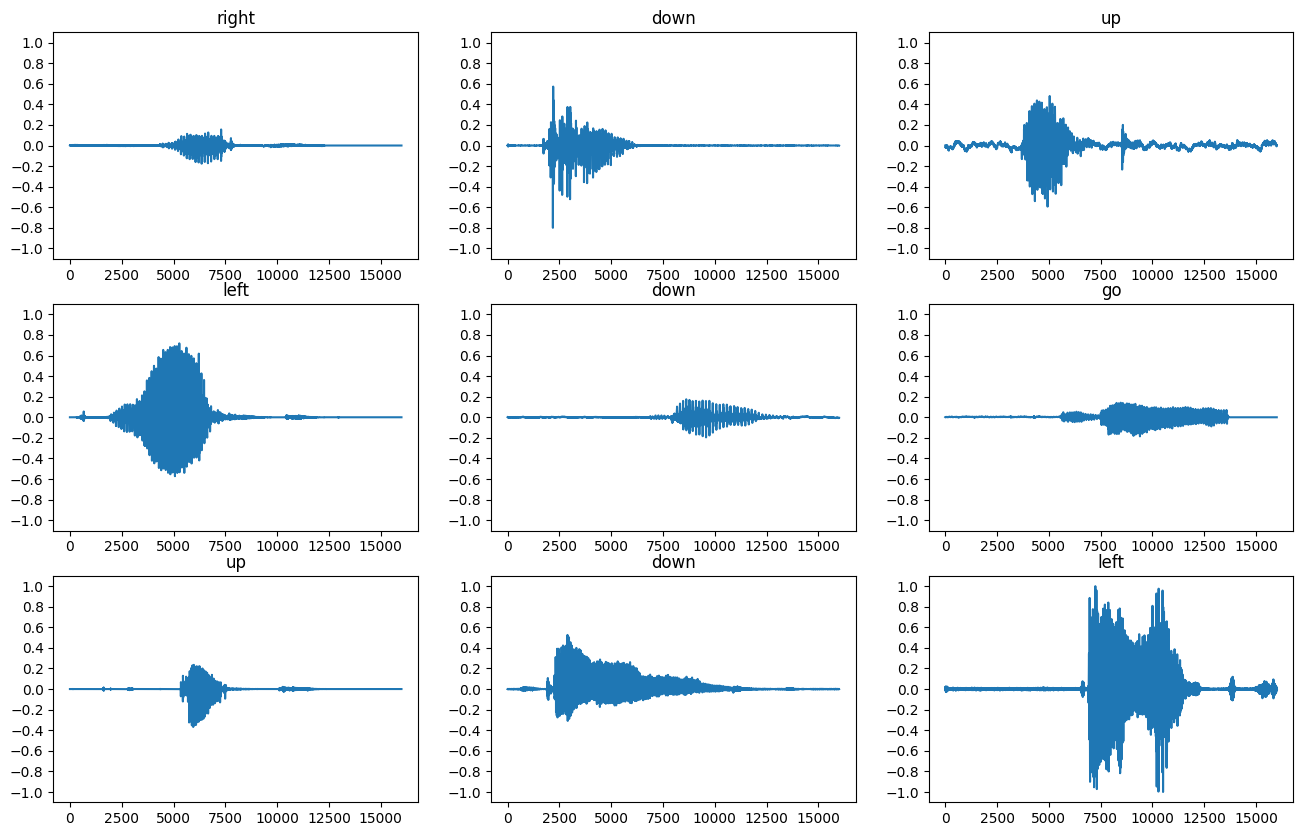

In [12]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

# Convert waveform to spectrograms

In [13]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [14]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

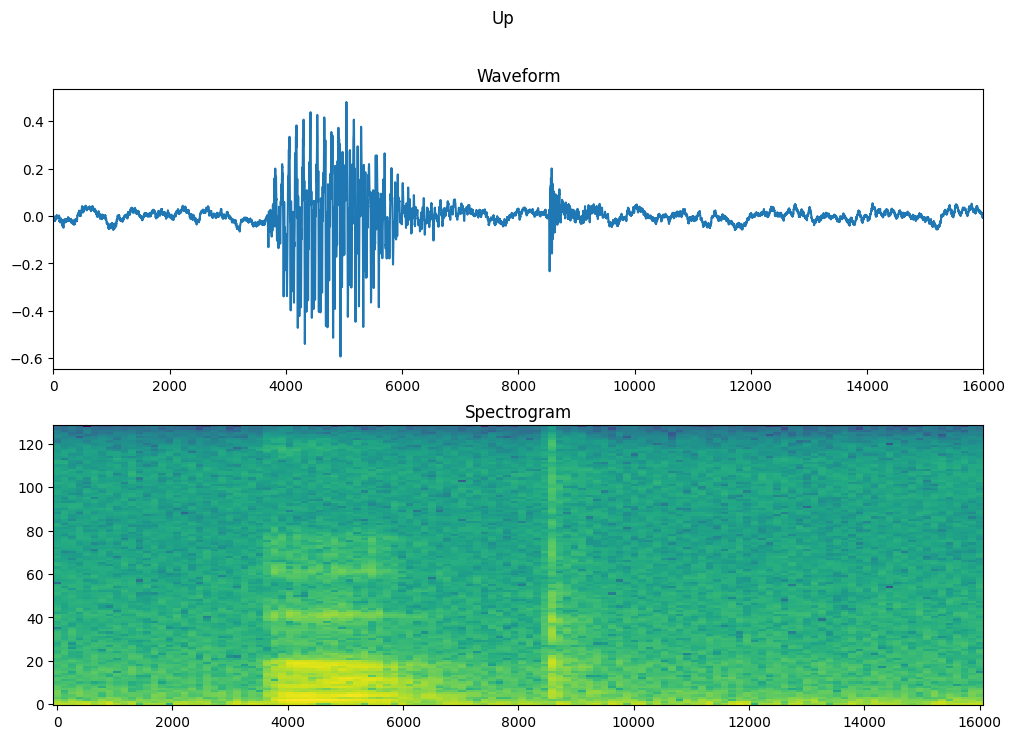

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [17]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

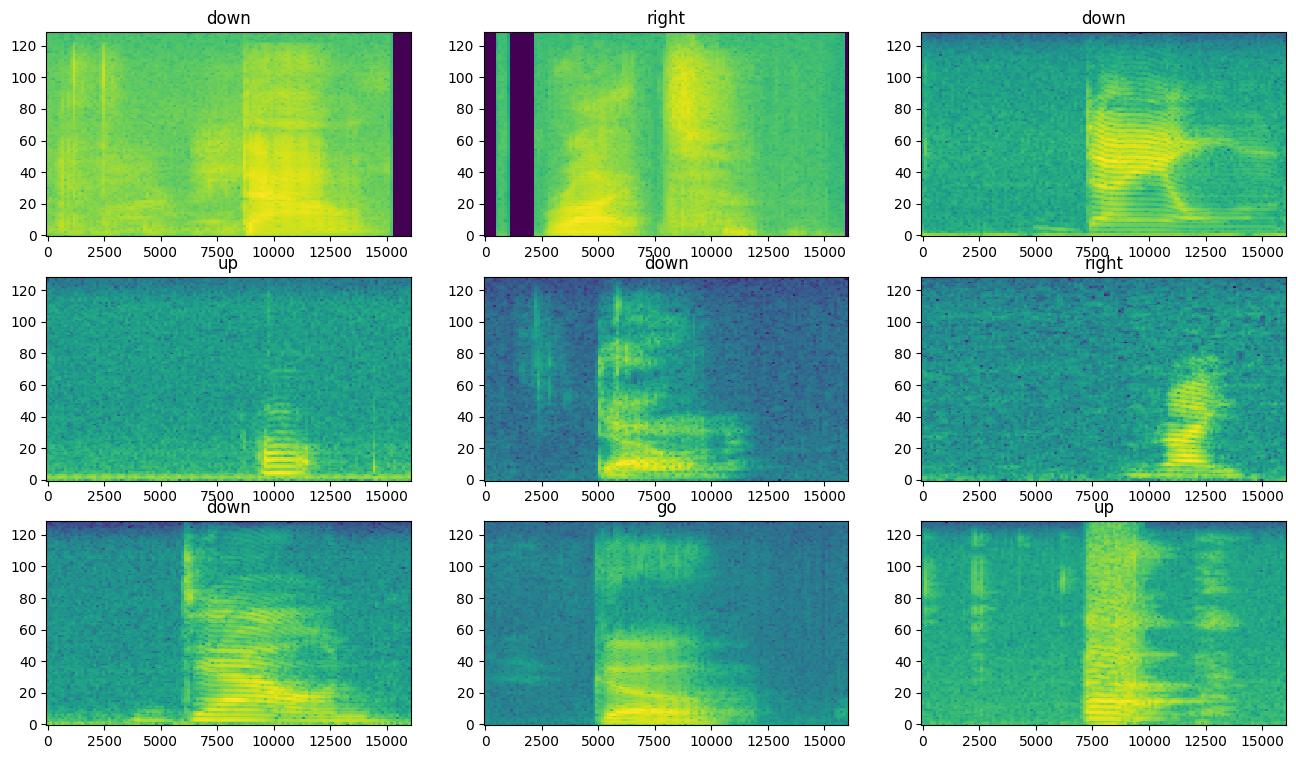

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

# Build + Train Model

In [21]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [22]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,113 (621.54 KB)

 Trainable params: 159,110 (621.52 KB)

 Non-trainable params: 3 (16.00 B)

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [24]:
EPOCHS = 25
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.2453 - loss: 1.7651 - val_accuracy: 0.5469 - val_loss: 1.3912
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4974 - loss: 1.4002 - val_accuracy: 0.6528 - val_loss: 1.0334
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6385 - loss: 1.0442 - val_accuracy: 0.7483 - val_loss: 0.7585
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7166 - loss: 0.8081 - val_accuracy: 0.8368 - val_loss: 0.5762
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7688 - loss: 0.6462 - val_accuracy: 0.8264 - val_loss: 0.5240
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7896 - loss: 0.5661 - val_accuracy: 0.8524 - val_loss: 0.4365
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8376 - loss: 0.4625 - val_accuracy: 0.8559 - val_loss: 0.4339
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8579 - loss: 0.3945 - val_accuracy: 0.8576 - val_loss

Text(0, 0.5, 'Accuracy [%]')

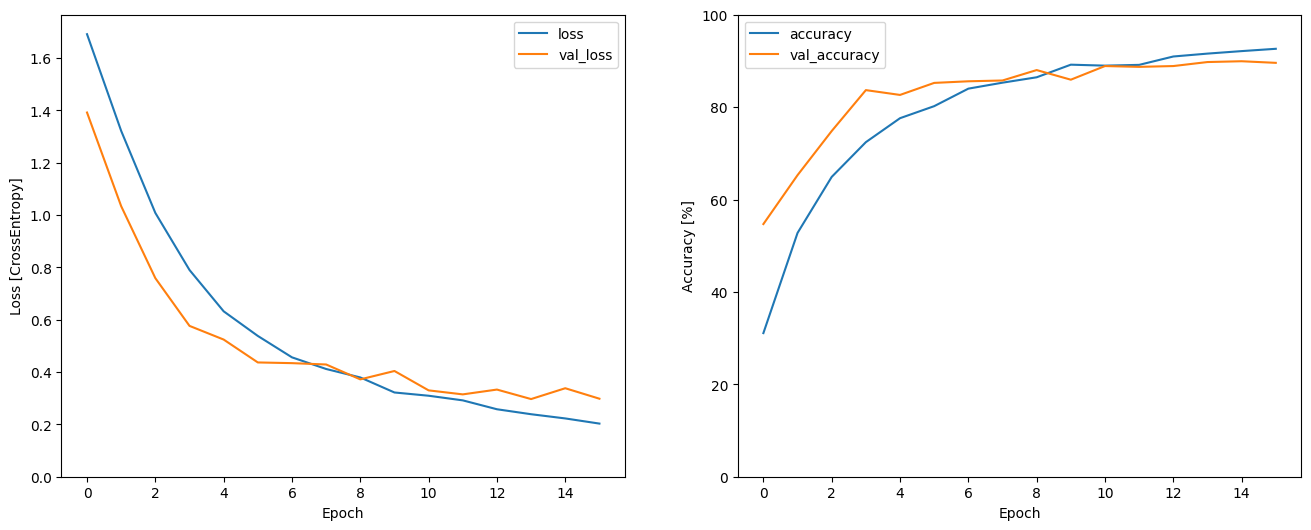

In [25]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

# Evaluate

In [26]:
model.evaluate(test_spectrogram_ds, return_dict=True)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9130 - loss: 0.3121


{'accuracy': 0.9086538553237915, 'loss': 0.3066105842590332}

In [27]:
y_pred = model.predict(test_spectrogram_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


In [28]:
y_pred = tf.argmax(y_pred, axis=1)

In [29]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

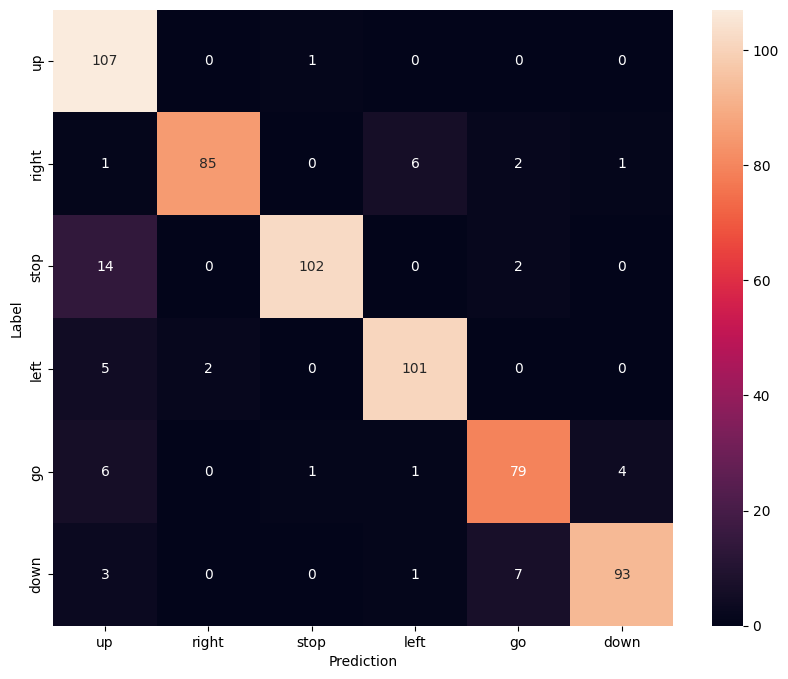

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Testing on our voices

In [31]:
from scipy.io import wavfile
import librosa
import soundfile as sf

path = '/content/drive/MyDrive/Colab Notebooks/audio recordings/right/record (21).wav'

audio, sample_rate = librosa.load(path, sr=16000)
sf.write(path, audio, 16000)

sample_rate, samples = wavfile.read(path)

print(sample_rate)
print(samples.shape)

16000
(16384,)


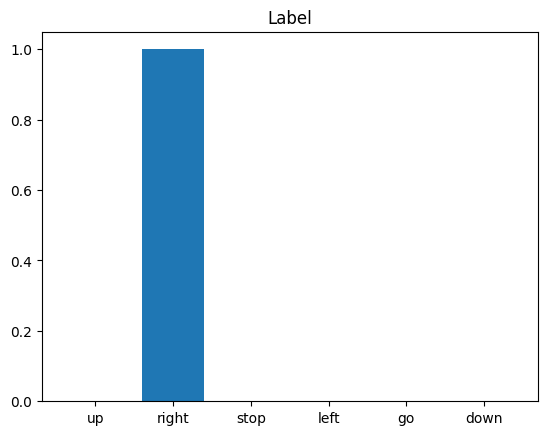

In [32]:
x = path
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names #have a feeling the order is completely wrong
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Label')
plt.show()

display.display(display.Audio(waveform, rate=16000))

# Model Info

In [33]:
layers = model.layers
layers

[<Resizing name=resizing, built=True>,
 <Normalization name=normalization, built=True>,
 <Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <MaxPooling2D name=max_pooling2d_2, built=True>,
 <Dropout name=dropout, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Dense name=dense_1, built=True>]

# Export Model

In [34]:
weights = model.get_weights()

for weight,layer in zip(weights, layers):
  print(f'{layer}: {weight}')

<Resizing name=resizing, built=True>: [0.12297514]
<Normalization name=normalization, built=True>: [0.5752712]
<Conv2D name=conv2d, built=True>: 0
<MaxPooling2D name=max_pooling2d, built=True>: [[[[-0.1075414   0.12880586 -0.01111593 -0.07922913 -0.19265613
     0.11614152  0.2231793  -0.00741391 -0.22065651 -0.05105581
    -0.3741775   0.07290834 -0.3371777   0.14112774 -0.19447806
     0.040631    0.03102825  0.074932   -0.14481983  0.15841287
     0.17601486  0.08201257  0.12532537 -0.02946742  0.13755575
     0.1614595   0.06602984  0.1344775   0.04918351 -0.42701057
    -0.01131594 -0.18185078]]

  [[-0.05815547  0.03535464  0.15555966  0.05536323  0.10147228
     0.17787953  0.10229465  0.1128387  -0.2508198  -0.14854231
    -0.34740722  0.19026335 -0.11867139 -0.1571664  -0.18729673
    -0.03007134  0.09740157  0.17595205  0.15740734  0.17288384
    -0.19598238  0.20834535  0.03878069  0.02903958  0.03157949
    -0.12377878 -0.06613181  0.15810701  0.10766338 -0.42239574
     0.

In [35]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

# ELF Method

In [40]:
!pip install pyinstaller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.4/346.4 kB 14.8 MB/s eta 0:00:00


In [42]:
!pip uninstall pathlib

Found existing installation: pathlib 1.0.1
Uninstalling pathlib-1.0.1:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/pathlib-1.0.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/pathlib.py
Proceed (Y/n)? Y
  Successfully uninstalled pathlib-1.0.1


In [43]:
!pyinstaller --onefile ECE243_SpeechCommands_Model.ipynb

355 INFO: PyInstaller: 6.12.0, contrib hooks: 2025.1
355 INFO: Python: 3.11.11
357 INFO: Platform: Linux-6.1.85+-x86_64-with-glibc2.35
358 INFO: Python environment: /usr
Script file 'ECE243_SpeechCommands_Model.ipynb' does not exist.


# To C

In [36]:
export = ExportModel(model)

In [37]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")

In [38]:
print(imported.signatures)


_SignatureMap({})


In [39]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
converter.optimizers = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpyp47y55i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  139899900218640: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  139899900215760: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  139899900216144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139899900219024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139899897623376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139899897625104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139899897624720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139899897625680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139899897624528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139899897626064: TensorSpec(shape=(), dtype=tf.resource, name=None